In [4]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

from itertools import product

In [5]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

def make_ws_graph(n, k, p = 0.1):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p = 0.5):
    """Returns True with probability `p`."""
    return np.random.random() < p

def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]


def make_ba_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

In [6]:
class Strategy:
    def __init__(self, mem_length, outcomes = None, cost = None):
        self.mem_length = mem_length
        histories = []
        for games_played in range(mem_length+1):
            histories.extend(product(['C','D'], repeat = games_played))
        n_histories = len(histories)
        if outcomes is None:
            outcomes = np.random.choice(['C','D'], size = n_histories)
        if len(outcomes) != n_histories:
            raise Exception('wrong number of outcomes')
        self.outcomes = outcomes
        if cost is None:
            self.cost = np.random.random()
        self.result_dict = dict(zip(histories, outcomes))
    def get_result(self, history):
        if len(history) > self.mem_length:
            history = history[-self.mem_length:]
        return self.result_dict[tuple(history)]
    def __str__(self):
        return ('%.2f '&self.cost)+(''.join(self.outcomes))
    
class Agent:
    def __init__(self, mem_length, strat = None, cost = None):
        if strat is None:
            self.next_strat = Strategy(mem_length, cost = cost)
        else:
            self.next_strat = strat
        if cost is not None:
            self.next_strat.cost = cost
        self.reset()
    def reset(self):
        self.fitness = 0
        self.strat = self.next_strat
    def __str__(self):
        return str(self.strat)

b = 1.5
results = {('C','C'):(1,1),
           ('D','D'):(0,0),
           ('C','D'):(0,b),
           ('D','C'):(b,0)}
            
def play_round(history, p0, p1):
    throw0 = p0.strat.get_result(history[1])
    throw1 = p1.strat.get_result(history[0])
    history[0].append(throw0)
    history[1].append(throw1)
    pay0,pay1 = results[(throw0,throw1)]
    p0.fitness += pay0
    p1.fitness += pay1
            
class Network:
    def __init__(self, constructor, N, mem_length, rounds=None, k=4, cost = None):
        if rounds is None:
            rounds = mem_length+1
        self.agents = np.array([Agent(mem_length, cost=cost) for _ in range(N)])
        self.network = constructor(N, k)
        nx.relabel.relabel_nodes(self.network, dict(enumerate(self.agents)), copy=False)
        self.rounds = rounds
        
        self.mean_fits     = []
        self.mean_costs    = []
        self.open_coops    = []
        self.nicenesses    = []

    def step(self):
        for (p1, p2) in self.network.edges:
            history = ([],[])
            for _ in range(self.rounds):
                play_round(history,p1,p2)
        for agent in self.agents:
            agent.fitness -= agent.strat.cost
        
        fits   =  [a.fitness       for a in self.agents]
        costs  =  [a.strat.cost    for a in self.agents]
        strats =  np.array([a.strat.outcomes    for a in self.agents])
        opens  =  np.array([a.strat.outcomes[0] for a in self.agents])
        
        mean_fit = np.mean(fits)
        mean_cost = np.mean(costs)
        open_coop = np.mean(opens  == 'C')
        niceness  = np.mean(strats == 'C')
        
        self.mean_fits.append(mean_fit)
        self.mean_costs.append(mean_cost)
        self.open_coops.append(open_coop)
        self.nicenesses.append(niceness)
        
        for agent in self.agents:
            neighborhood = list(self.network[agent])
            neighborhood.append(agent)
            fits = np.array([a.fitness for a in neighborhood])
            index = np.random.choice(np.flatnonzero(fits == fits.max()))
            agent.next_strat = neighborhood[index].strat
        for agent in self.agents:
            agent.reset()

In [56]:
def run_network(net, T = 400):
    for _ in range(T):
        net.step() 

def plot_network(net, **plt_options):
    plt_options['alpha'] = 0.15
    plt.subplot(2,2,1)
    plt.plot(net.mean_fits, **plt_options)
    plt.ylabel('mean fitness')
    plt.xlabel('time')

    plt.subplot(2,2,2)
    plt.plot(net.mean_costs, **plt_options)
    plt.ylabel('mean cost')
    plt.xlabel('time')

    plt.subplot(2,2,3)
    plt.plot(net.open_coops, **plt_options)
    plt.ylabel('proportion of openning cooperators')
    plt.xlabel('time')

    plt.subplot(2,2,4)
    plt.plot(net.nicenesses, **plt_options)
    plt.ylabel('niceness')
    plt.xlabel('time')

def plot_result(constructor, N, mem, title, reps = 10, T = 400):
    mean_fits = []
    mean_costs = []
    mean_opens = []
    mean_nice = []
    mean_fits_nocost = []
    mean_costs_nocost = []
    mean_opens_nocost = []
    mean_nice_nocost = []
    
    print(0)
    cost = Network(constructor, N, mem)
    run_network(cost,T)
    mean_fits.append(cost.mean_fits)
    mean_costs.append(cost.mean_costs)
    mean_opens.append(cost.open_coops)
    mean_nice.append(cost.nicenesses)
    
    no_cost = Network(constructor, N, mem, cost = 0)
    run_network(no_cost,T)
    mean_fits_nocost.append(no_cost.mean_fits)
    mean_costs_nocost.append(no_cost.mean_costs)
    mean_opens_nocost.append(no_cost.open_coops)
    mean_nice_nocost.append(no_cost.nicenesses)
    
    plt.figure(figsize = (13,8))
    plt.suptitle(title)
    plot_network(cost,   color='C0',label='_nolegend_')
    plot_network(no_cost,color='C1',label='_nolegend_')
    for i in range(reps-1):
        print((i+1)/reps)
        
        cost = Network(constructor, N, mem)
        run_network(cost,T)
        mean_fits.append(cost.mean_fits)
        mean_costs.append(cost.mean_costs)
        mean_opens.append(cost.open_coops)
        mean_nice.append(cost.nicenesses)
        
        no_cost = Network(constructor, N, mem, cost = 0)
        run_network(no_cost,T)
        mean_fits_nocost.append(no_cost.mean_fits)
        mean_costs_nocost.append(no_cost.mean_costs)
        mean_opens_nocost.append(no_cost.open_coops)
        mean_nice_nocost.append(no_cost.nicenesses)
        
        plot_network(cost,   color='C0',label='_nolegend_')
        plot_network(no_cost,color='C1',label='_nolegend_')
    print(1)
    mean_fits = np.mean(mean_fits, axis = 0)
    mean_costs = np.mean(mean_costs, axis = 0)
    mean_opens = np.mean(mean_opens, axis = 0)
    mean_nice = np.mean(mean_nice, axis = 0)
    mean_fits_nocost = np.mean(mean_fits_nocost, axis = 0)
    mean_costs_nocost = np.mean(mean_costs_nocost, axis = 0)
    mean_opens_nocost = np.mean(mean_opens_nocost, axis = 0)
    mean_nice_nocost = np.mean(mean_nice_nocost, axis = 0)
    
    plt.subplot(2,2,1)
    plt.plot(mean_fits, color='C0',label='cost', linewidth = 3)
    plt.plot(mean_fits_nocost, color='C1',label='no cost', linewidth = 3)
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(mean_costs, color='C0',label='cost', linewidth = 3)
    plt.plot(mean_costs_nocost, color='C1',label='no cost', linewidth = 3)
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(mean_opens, color='C0',label='cost', linewidth = 3)
    plt.plot(mean_opens_nocost, color='C1',label='no cost', linewidth = 3)
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(mean_nice, color='C0',label='cost', linewidth = 3)
    plt.plot(mean_nice_nocost, color='C1',label='no cost', linewidth = 3)
    plt.legend()
    
    plt.savefig(title+'.png')

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


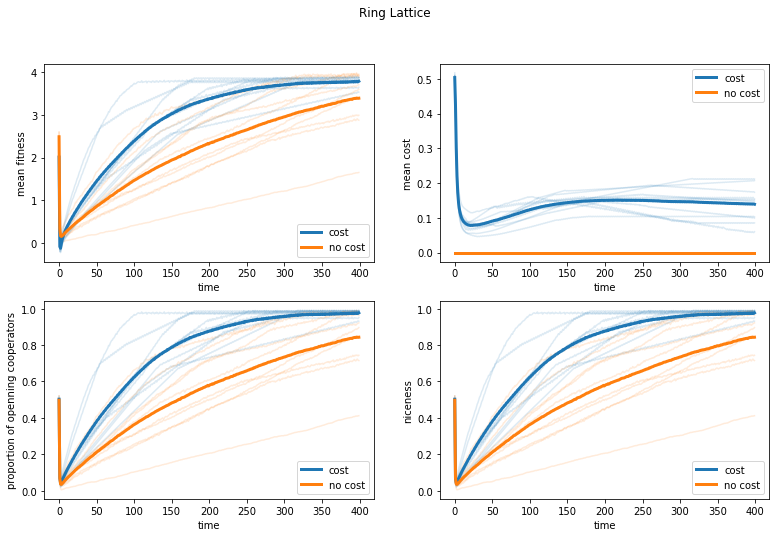

In [57]:
plot_result(make_ring_lattice, 1000, 0, 'Ring Lattice')

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


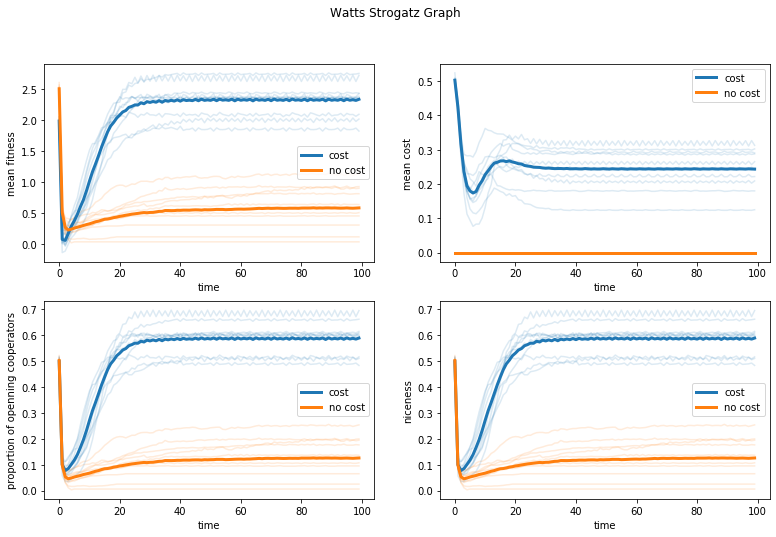

In [58]:
plot_result(make_ws_graph, 1000, 0, 'Watts Strogatz Graph', T=100)

0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1


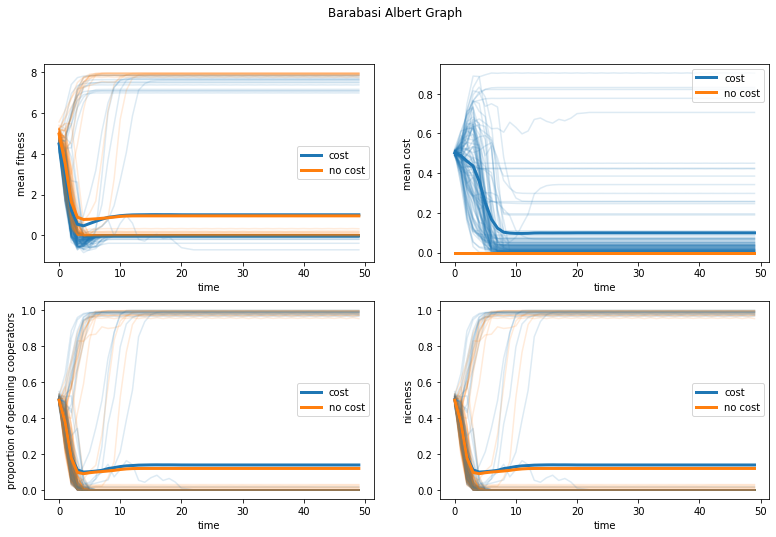

In [63]:
plot_result(make_ba_graph, 1000, 0, 'Barabasi Albert Graph', T=50, reps = 100)

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


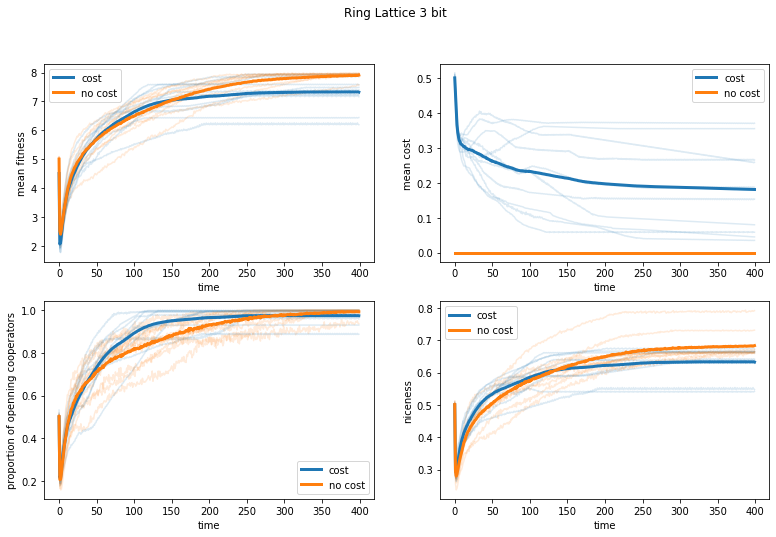

In [60]:
plot_result(make_ring_lattice, 1000, 1, 'Ring Lattice 3 bit')

0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


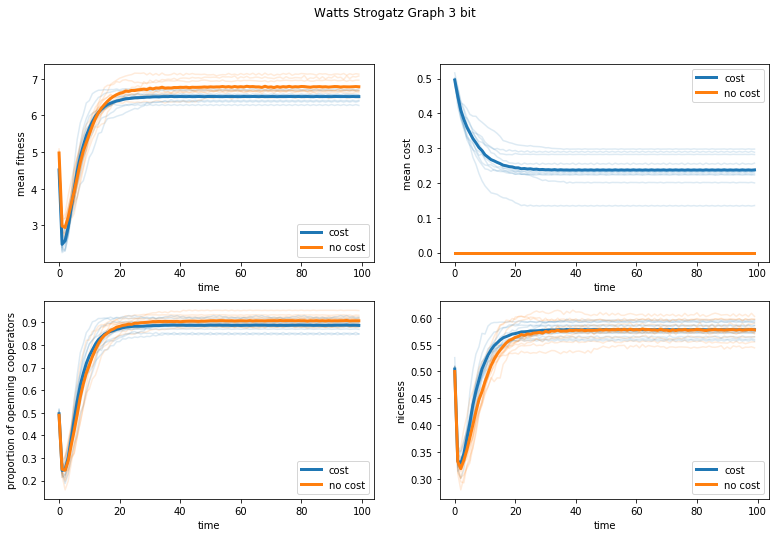

In [61]:
plot_result(make_ws_graph, 1000, 1, 'Watts Strogatz Graph 3 bit', T=100)

0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1


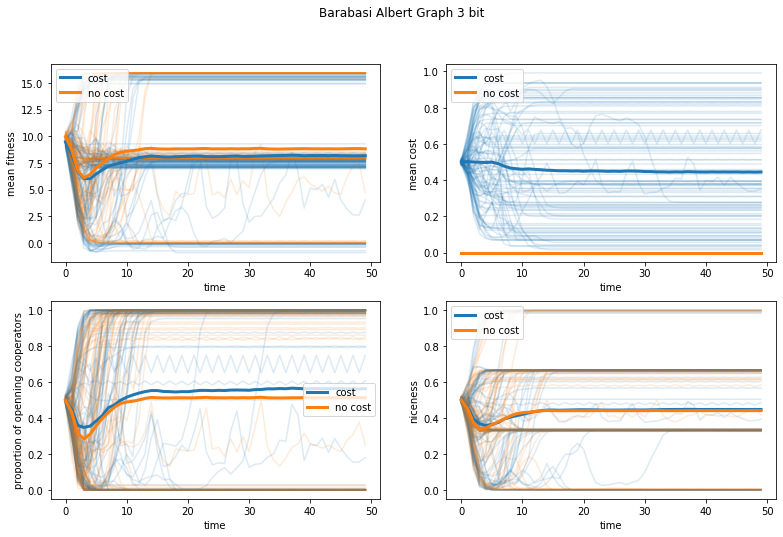

In [64]:
plot_result(make_ba_graph, 1000, 1, 'Barabasi Albert Graph 3 bit', T=50, reps = 100)